# CNN + GlobalAvgPool
Derived from notebook LSTM 132. 

Combined cell lines. Coding RNA up to 4K. 



In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-19 00:18:10.454572
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=4000   

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_noncoding_train_genes.csv'
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_noncoding_train_counts.K4.gc42.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1,7]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Exclude cell line 1 H1.hESC
Exclude cell line 7 NCI.H460


## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions=[]):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        overall_count = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_max = None
                    rci_count = 0
                    cell_line = 0 # first line is 0 = A549
                    for rci_str in fields:
                        if rci_str != "nan" and cell_line not in exclusions:
                            rci_val = float(rci_str)
                            if rci_max is None or rci_val > rci_max:
                                rci_max = rci_val
                            rci_count += 1
                        cell_line += 1   
                    if rci_count > 0:
                        gene_to_rci[gene_id] = rci_max
                        overall_sum += rci_max
                        overall_count += 1
        overall_mean = overall_sum / overall_count
        print('Number of RCI values',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [7]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Num labels:',len(labels))
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num sequences:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-19 00:18:47.988627
Load RCI values...
Number of RCI values 3952
Mean RCI value -0.394721008327429
Num RCI: 3952
Example RCI: [('ENSG00000099869', 0.00846158), ('ENSG00000105501', 0.363348), ('ENSG00000116652', -1.848)]
Load genes...
2023-01-19 00:18:51.159712
Load sequence...
2023-01-19 00:19:15.025365
Num IDs: 19406
Example IDs: [('ENSG00000241860', 'ENST00000662089.1'), ('ENSG00000237491', 'ENST00000657896.1'), ('ENSG00000237491', 'ENST00000589899.5'), ('ENSG00000237491', 'ENST00000593022.5')]
Count 10307 ones out of 19406 labels.
Num labels: 19406
Example labels: [0, 0, 0, 0]
Num sequences: 19406
Example sequence: [133, 17, 67, 12, 48, 190, 247, 217, 99, 138, 37, 148, 78, 56, 224, 125, 241, 193, 1, 4, 15, 57, 228, 144, 62, 245, 209, 66, 5, 19, 75, 41, 163, 139, 41, 163, 137, 36, 141, 49, 195, 11, 41, 161, 131, 10, 40, 158, 119, 217, 99, 139, 41, 161, 131, 9, 35, 137, 33, 129, 1, 1, 1, 1, 1, 1, 2, 8, 31, 123, 233, 161, 131, 11, 41, 163, 137, 33, 129, 4, 14, 53, 212, 77, 51, 2

## Model

In [8]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [9]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-01-19 00:19:15.056248
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [10]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1)  # verbose=1 for ascii art, verbose=0 for none
                    # validation_data=(X_valid,y_valid) )
            print(datetime.now())
            tf.keras.backend.clear_session()
            gc.collect()

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print('Train sizes',X_train.shape,y_train.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            X_train = None
            y_train = None
            train_genes = None

            print("Compute valiation accuracy")
            print(datetime.now())
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            yhat_classes = None
            X_valid = None
            y_valid = None
            valid_genes = None
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            model = None
            history = None
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2023-01-19 00:19:18.103408
2023-01-19 00:19:18.103537
splitting
Fold 1
Training example
[121 228 142 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-19 00:19:21.231856
Epoch 1/3
490/490 [==============================] - 12s 8ms/step - loss: 0.6928 - accuracy: 0.5174
Epoch 2/3
490/490 [==============================] - 3s 6ms/step - loss: 0.6920 - accuracy: 0.5227
Epoch 3/3
490/490 [==============================] - 3s 6ms/step - loss: 0.6851 - accuracy: 0.5486
2023-01-19 00:19:42.855868


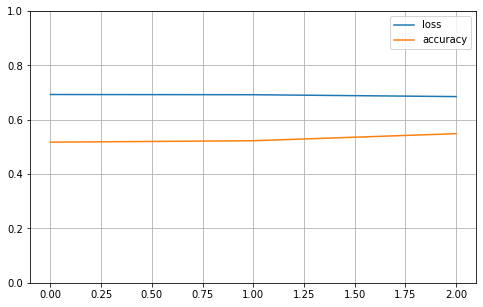

Train sizes (15650, 3997) (15650, 1)
Train set ones/size 8121 / 15650
Compute valiation accuracy
2023-01-19 00:19:43.530457
Valid sizes (3756, 3997) (3756, 1)
Valid set ones/size 2186 / 3756
Range of scores: 0.25482875 to 0.7964134
Predicted zeros and ones 801 2955
Accuracy: 59.24% Precision: 61.08% Recall: 82.57% F1: 70.22%
2023-01-19 00:19:45.048542
Fold 2
Training example
[186 229 146 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-19 00:19:48.010210
Epoch 1/3
476/476 [==============================] - 4s 7ms/step - loss: 0.6890 - accuracy: 0.5479
Epoch 2/3
476/476 [==============================] - 3s 6ms/step - loss: 0.6873 - accuracy: 0.5481
Epoch 3/3
476/476 [==============================] - 3s 6ms/step - loss: 0.6792 - accuracy: 0.5678
2023-01-19 00:19:59.174475


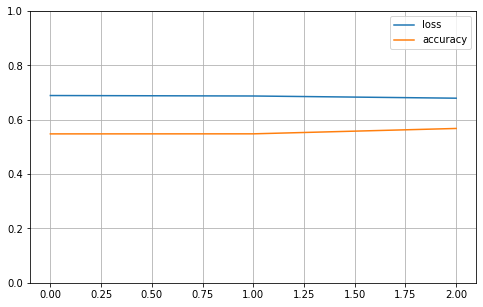

Train sizes (15226, 3997) (15226, 1)
Train set ones/size 8342 / 15226
Compute valiation accuracy
2023-01-19 00:19:59.844719
Valid sizes (4180, 3997) (4180, 1)
Valid set ones/size 1965 / 4180
Range of scores: 0.25931972 to 0.8758781
Predicted zeros and ones 974 3206
Accuracy: 52.46% Precision: 49.66% Recall: 81.02% F1: 61.57%
2023-01-19 00:20:01.527248
Fold 3
Training example
[186 229 146 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-19 00:20:04.607598
Epoch 1/3
498/498 [==============================] - 4s 7ms/step - loss: 0.6905 - accuracy: 0.5389
Epoch 2/3
498/498 [==============================] - 3s 6ms/step - loss: 0.6881 - accuracy: 0.5435
Epoch 3/3
498/498 [==============================] - 3s 6ms/step - loss: 0.6775 - accuracy: 0.5693
2023-01-19 00:20:15.817817


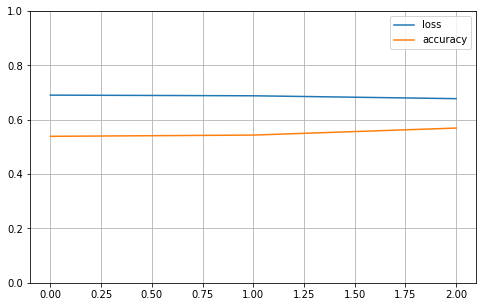

Train sizes (15916, 3997) (15916, 1)
Train set ones/size 8585 / 15916
Compute valiation accuracy
2023-01-19 00:20:16.449679
Valid sizes (3490, 3997) (3490, 1)
Valid set ones/size 1722 / 3490
Range of scores: 0.15581006 to 0.93424976
Predicted zeros and ones 573 2917
Accuracy: 49.83% Precision: 49.50% Recall: 83.86% F1: 62.25%
2023-01-19 00:20:17.554601
Fold 4
Training example
[186 229 146 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-19 00:20:20.535487
Epoch 1/3
483/483 [==============================] - 4s 6ms/step - loss: 0.6926 - accuracy: 0.5179
Epoch 2/3
483/483 [==============================] - 3s 6ms/step - loss: 0.6916 - accuracy: 0.5245
Epoch 3/3
483/483 [==============================] - 3s 6ms/step - loss: 0.6830 - accuracy: 0.5609
2023-01-19 00:20:31.513273


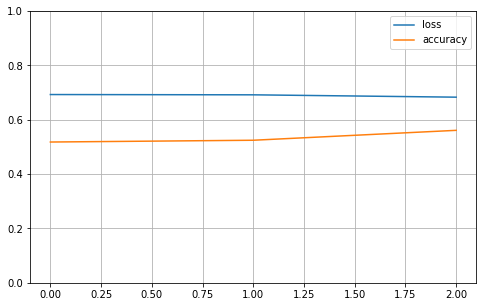

Train sizes (15440, 3997) (15440, 1)
Train set ones/size 8032 / 15440
Compute valiation accuracy
2023-01-19 00:20:32.156121
Valid sizes (3966, 3997) (3966, 1)
Valid set ones/size 2275 / 3966
Range of scores: 0.09847913 to 0.88912666
Predicted zeros and ones 1022 2944
Accuracy: 55.70% Precision: 58.80% Recall: 76.09% F1: 66.33%
2023-01-19 00:20:33.388095
Fold 5
Training example
[186 229 146 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-19 00:20:36.344392
Epoch 1/3
481/481 [==============================] - 3s 6ms/step - loss: 0.6917 - accuracy: 0.5288
Epoch 2/3
481/481 [==============================] - 3s 6ms/step - loss: 0.6884 - accuracy: 0.5432
Epoch 3/3
481/481 [==============================] - 3s 6ms/step - loss: 0.6779 - accuracy: 0.5693
2023-01-19 00:20:47.244883


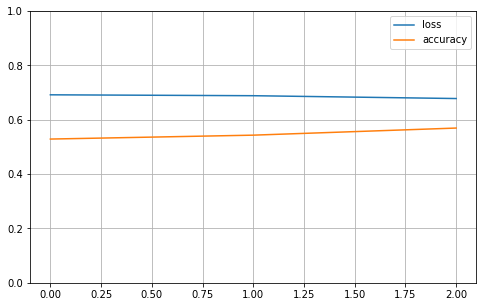

Train sizes (15392, 3997) (15392, 1)
Train set ones/size 8148 / 15392
Compute valiation accuracy
2023-01-19 00:20:47.888150
Valid sizes (4014, 3997) (4014, 1)
Valid set ones/size 2159 / 4014
Range of scores: 0.16865225 to 0.89264154
Predicted zeros and ones 415 3599
Accuracy: 53.51% Precision: 54.07% Recall: 90.13% F1: 67.59%
2023-01-19 00:20:49.159586

Cross validation 5 folds 3 epochs
 accuracy mean 54.15% +/- 3.17
 precision mean 54.62% +/- 4.70
 recall mean 82.73% +/- 4.54
 F1 mean 65.60% +/- 3.26
2023-01-19 00:20:49.160669


In [11]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
cvdo = None
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())